PART 1 - EVALUATING RBF KERNELS

In [ ]:
import numpy as np
from numba import cuda, float32
import numba
import matplotlib.pyplot as plt
import math 


# RBF code from lectures


m = 400
n = 50

sigma = .1

plot_grid = np.mgrid[0:1:m * 1j, 0:1:m * 1j]

targets_xy = np.vstack((plot_grid[0].ravel(),
                        plot_grid[1].ravel(),
                        np.zeros(plot_grid[0].size))).T
targets_xz = np.vstack((plot_grid[0].ravel(),
                        np.zeros(plot_grid[0].size),
                        plot_grid[1].ravel())).T
targets_yz = np.vstack((np.zeros(plot_grid[0].size),
                       plot_grid[0].ravel(),
                       plot_grid[1].ravel())).T

targets = np.vstack((targets_xy, targets_xz, targets_yz))

rand = np.random.RandomState(0)

# We are picking random sources

sources = rand.rand(n, 3)

weights = rand.rand(len(sources))

def visualize(result, npoints):
    """A helper function for visualization"""
    
    result_xy = result[: npoints * npoints].reshape(npoints, npoints).T
    result_xz = result[npoints * npoints : 2 * npoints * npoints].reshape(npoints, npoints).T
    result_yz = result[2 * npoints * npoints:].reshape(npoints, npoints).T

    fig = plt.figure(figsize=(20, 20))    

    ax = fig.add_subplot(1, 3, 1)   
    im = ax.imshow(result_xy, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    ax = fig.add_subplot(1, 3, 2)   
    im = ax.imshow(result_xz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('x')
    ax.set_ylabel('z')

    ax = fig.add_subplot(1, 3, 3)   
    im = ax.imshow(result_yz, extent=[0, 1, 0, 1], origin='lower')
    ax.set_xlabel('y')
    ax.set_ylabel('z')


# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPB_x x TPB_y elements.
TPB_x = 16 
TPB_y = 32

l = ((targets.shape[0] + TPB_x - 1)) //TPB_x
p = (n + TPB_y -1)//TPB_y




In [ ]:
# Launching cuda kernel
@cuda.jit
def intermediate_results(sources, targets, weights, device_intermediate_result):
    local_result = cuda.shared.array((TPB_x, TPB_y), numba.float32)
    local_targets = cuda.shared.array((TPB_x, 3), numba.float32)
    local_sources = cuda.shared.array((TPB_y, 3), numba.float32)
    local_weights = cuda.shared.array(TPB_y, numba.float32)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    block_y = cuda.blockIdx.y

    px, py = cuda.grid(2)
    
    if px >= targets.shape[0] and py >= sources.shape[0]:
        return

    
    # At first we are loading all the targets into the shared memory
    # We use only the first column of threads to do this.
      
    if ty == 0:
        for index in range(3):
            local_targets[tx, index] = targets[px, index]
    
    # We are now loading all the sources and weights.
    # We only require the first row of threads to do this.
    
    if tx == 0:
        for index in range(3):
            local_sources[ty, index] = sources[py, index]
        local_weights[ty] = weights[py]
        
    # Let us now sync all threads
    
    cuda.syncthreads()
    
    # Now compute the interactions
    
    squared_diff = numba.float32(0)
    
    for index in range(3):
        squared_diff += (local_targets[tx, index] - local_sources[ty, index])**2
    local_result[tx, ty] = math.exp(-squared_diff / ( numba.float32(2) * numba.float32(sigma)**2)) * local_weights[ty]
    
    cuda.syncthreads()
    
    # Now sum up all the local results
    if ty == 0:
      res = numba.float32(0)
      for index in range(TPB_y):
          res += local_result[tx, index]
      device_intermediate_result[px, block_y] = res 

In [ ]:
@cuda.jit
def summation_kernel(device_intermediate_result, result):
    tx = cuda.threadIdx.x

    bpg = cuda.gridDim.x    # Blocks per grid

    px = cuda.grid(1)

    if px >= device_intermediate_result.shape[0]:
      # Quit if (px, py) is outside of valid device_intermediate_result boundary
      return

    # We are adding rows of the device_intermediate_result to sum
    sum = numba.float32(0)
    for i in range(device_intermediate_result.shape[1]):
      sum += device_intermediate_result[px, i]
    result[px] = sum

In [ ]:
# Move sources, weights, targets to device
device_sources = cuda.to_device(sources)
device_weights = cuda.to_device(weights)
device_targets = cuda.to_device(targets)

In [ ]:
device_intermediate_result = cuda.device_array((len(targets),p), dtype=np.float32)
device_result = cuda.device_array((len(targets),), dtype=np.float32)
l*TPB_x

480000

In [ ]:
intermediate_results[(l, p), (TPB_x, TPB_y)] (device_sources, device_targets, device_weights, device_intermediate_result)

In [ ]:
summation_kernel[l, TPB_x] (device_intermediate_result, device_result)

In [ ]:
# Copy data back to host 
intermediate_result = device_intermediate_result.copy_to_host()
result = device_result.copy_to_host()
intermediate_result

array([[1.8632311e-03, 3.0624284e-10],
       [1.9987950e-03, 3.2998246e-10],
       [2.1429064e-03, 3.5534681e-10],
       ...,
       [8.0545660e-06, 1.2174401e-08],
       [7.9701322e-06, 1.0615391e-08],
       [7.8819048e-06, 9.2506278e-09]], dtype=float32)

In [ ]:
result

array([1.8632314e-03, 1.9987952e-03, 2.1429069e-03, ..., 8.0667405e-06,
       7.9807478e-06, 7.8911553e-06], dtype=float32)

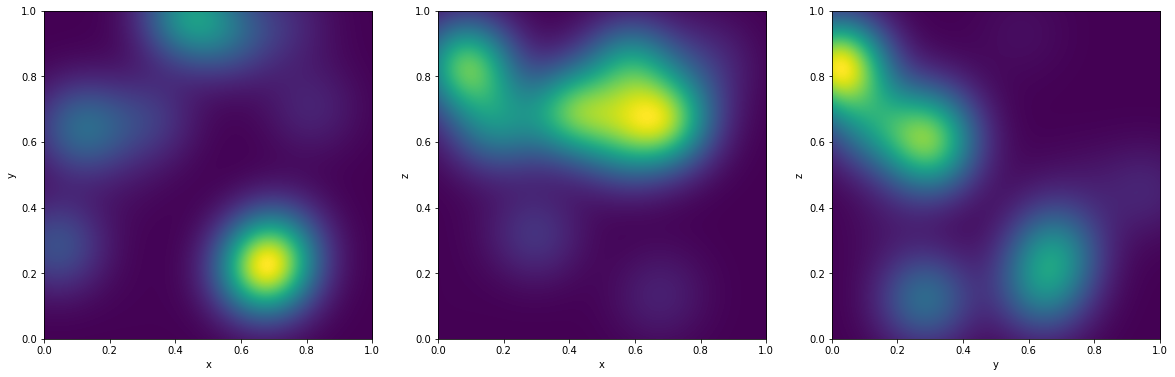

In [ ]:
visualize(result, m)  # Run visualise function for comparison

In [ ]:
%timeit intermediate_results(sources, targets, weights, device_intermediate_result)

100 loops, best of 3: 7.09 ms per loop


Experimenting with runtime results for varying numbers of sources and targets




In [ ]:
TPB_x = 16 
TPB_y = 32
sourcesArray = [50, 100, 150, 200]
targetsArray = [100, 200, 300, 400]
timeArray = []
l = ((targets.shape[0] + TPB_x - 1)) //TPB_x
p = (n + TPB_y -1)//TPB_y

for n in sourcesArray:
  for m in targetsArray:
    %timeit intermediate_results(sources, targets, weights, device_intermediate_result)



100 loops, best of 3: 7.11 ms per loop
100 loops, best of 3: 7.09 ms per loop
100 loops, best of 3: 7.01 ms per loop
100 loops, best of 3: 7.05 ms per loop
100 loops, best of 3: 7 ms per loop
100 loops, best of 3: 7.05 ms per loop
100 loops, best of 3: 7.03 ms per loop
100 loops, best of 3: 6.96 ms per loop
100 loops, best of 3: 7.01 ms per loop
100 loops, best of 3: 6.97 ms per loop
100 loops, best of 3: 6.99 ms per loop
100 loops, best of 3: 6.98 ms per loop
100 loops, best of 3: 6.99 ms per loop
100 loops, best of 3: 6.91 ms per loop
100 loops, best of 3: 6.91 ms per loop
100 loops, best of 3: 6.97 ms per loop


Validating the result against numba




In [ ]:
import numpy as np
import numba

sigma = .1

@numba.njit(parallel=True)
def rbf_evaluation(sources, targets, weights, result):
    """Evaluate the RBF sum."""
    
    n = len(sources)
    m = len(targets)
        
    result[:] = 0
    for index in numba.prange(m):
        result[index] = np.sum(np.exp(-np.sum(np.abs(targets[index] - sources)**2, axis=1) / (2 * sigma**2)) * weights)

numba_result = np.zeros(len(targets), dtype=np.float32)
rbf_evaluation(sources, targets, weights, numba_result)


In [ ]:
rel_error = np.linalg.norm(result - numba_result, np.inf) / np.linalg.norm(numba_result, np.inf)
print(f"Error: {round(rel_error, 2)}.")


Error: 0.0.


In [ ]:
%timeit rbf_evaluation(sources, targets, weights, result)

1 loop, best of 3: 770 ms per loop


PART 2 - EVALUATING THE DISCRETE LAPLACIAN ON GPUS

In [ ]:
# Code from the lecture to compare our final result
import numba
import numpy as np


from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

In [ ]:
from numba import cuda, float32
import numba
import random

TPB = 32
N = 1000
h = 1/(N-1)

x = rand.randn(N * N)
input_matrix = x.reshape((N,N)) #Input ui,j matrix
device_input_matrix = cuda.to_device(input_matrix) #Input matrix moved to cuda device
device_result =  cuda.device_array((N, N), dtype=np.float64) #The array on cuda device to store result


In [ ]:
A, _ = discretise_poisson(N)

# Generate a random vector
rand = np.random.RandomState(0)


y_exact = A @ x

In [ ]:
@cuda.jit
def poisson_kernel(input_matrix, result):

  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y

  bx = cuda.blockIdx.x
  by = cuda.blockIdx.y

  px, py = cuda.grid(2)

  if (px >= result.shape[0] or py >= result.shape[1]):
    return

  if px == 0 or px == N - 1 or py == 0 or py == N -1 :
    result[px, py] = input_matrix[px,py]
  
  else:
    result[px, py] =  (4*input_matrix[px, py] -
                          input_matrix[px-1, py] - 
                          input_matrix[px+1, py] - 
                          input_matrix[px, py-1] - 
                          input_matrix[px, py+1] )/ (h**2)

In [ ]:
nbg = (N + TPB -1)//TPB
poisson_kernel[(nbg, nbg), (TPB, TPB)](device_input_matrix, device_result)
result = device_result.copy_to_host()
result.reshape(N,N)

array([[ 1.12663592e+00, -1.07993151e+00, -1.14746865e+00, ...,
         5.31042507e-01,  2.39145581e-01,  1.39789626e+00],
       [ 5.51713548e-02,  1.29388563e+06,  9.74619227e+06, ...,
         4.94366638e+06,  1.88566120e+05, -1.60732016e+00],
       [-9.65953859e-01, -2.01404511e+06, -3.29785803e+06, ...,
        -2.61738457e+05,  3.55635086e+05, -2.86318281e-01],
       ...,
       [ 1.02337850e+00, -3.40045323e+06,  1.05043654e+07, ...,
         3.04358947e+06, -2.87604307e+06, -9.46757567e-01],
       [ 2.21318927e-01, -2.60070964e+06,  1.37897035e+06, ...,
         1.23426842e+06, -5.87828192e+06, -3.59507796e-01],
       [ 1.61819248e+00, -2.20155375e-01,  9.72412086e-01, ...,
         1.07217389e+00, -2.87949776e-01,  1.56397790e+00]])

Validating result

In [ ]:
result = result.reshape(-1)
rel_error = np.linalg.norm(result - y_exact, np.inf) / np.linalg.norm(y_exact, np.inf)
print(f"Error: {round(rel_error, 2)}.")

Error: 0.0.


Result for growing matrix size N

In [ ]:
TPB = 32
nArray = [100, 1000, 2000, 4000, 6000, 8000, 10000]
h = 1/(N-1)
timeArray = []

for N in nArray:
  x = rand.randn(N * N)
  input_matrix = x.reshape((N,N)) 
  device_input_matrix = cuda.to_device(input_matrix) 

  
  nbg = (N + TPB -1)//TPB
  %timeit poisson_kernel[(nbg, nbg), (TPB, TPB)](device_input_matrix, device_result)
  result = device_result.copy_to_host()



The slowest run took 35.22 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 84 ns per loop
The slowest run took 8.77 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 117 ns per loop
The slowest run took 10.57 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 115 ns per loop
The slowest run took 9.47 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 115 ns per loop
The slowest run took 10.20 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 114 ns per loop
The slowest run took 8.89 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 115 ns per loop
The slowest run took 8.47 times 

In current code for poisson_kernel, every thread is communicating with a global variable in global memory which is not very efficient. However, it would be faster to copy the input in parts into shared memory. It could be done by replacing if/else conditions in poisson_kernel function with: 

if (px==0) or (py==0) or (px==N-1) or(py=N-1):
   
   Store the boundary value in the result

elif (tx==0) or (ty==0) or (tx==TPB-1) or(ty=TPB-1):

Use the global storage input_matrix to calculate the result, you do not have access to u_i-1,j or ui+1,j etc. in shared memory

else:

Use shared memory to do the same calculation
    

 